In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from python_code import homoskedastic_model as hsk
from python_code import gibbs_sampler as gs
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import pickle

In [2]:
df=pd.read_csv('../data/greenbuildings.csv')
y = ((df['Rent']*df['leasing_rate'])/100).to_numpy()
X = df[['green_rating', 'City_Market_Rent', 'age','class_a', 'class_b']].to_numpy()
X_intercept = sm.add_constant(X)

In [4]:
gibbs = gs.GibbsSampler(X, y, n_iter=3000)
gibbs.fit()
with open('traces.pickle', 'wb') as handle:
    pickle.dump(gibbs.traces, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [14:51<00:00,  3.36it/s]


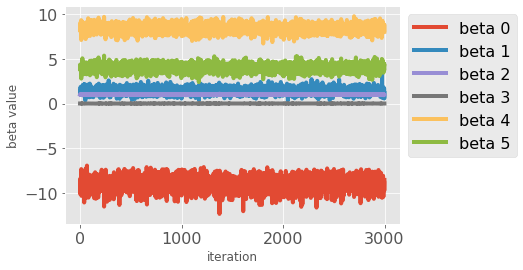

In [14]:
for i in range(6):
    plt.plot(gibbs.traces['beta_trace'][:,i], label=f'beta {i}');
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('iteration')
plt.ylabel('beta value');

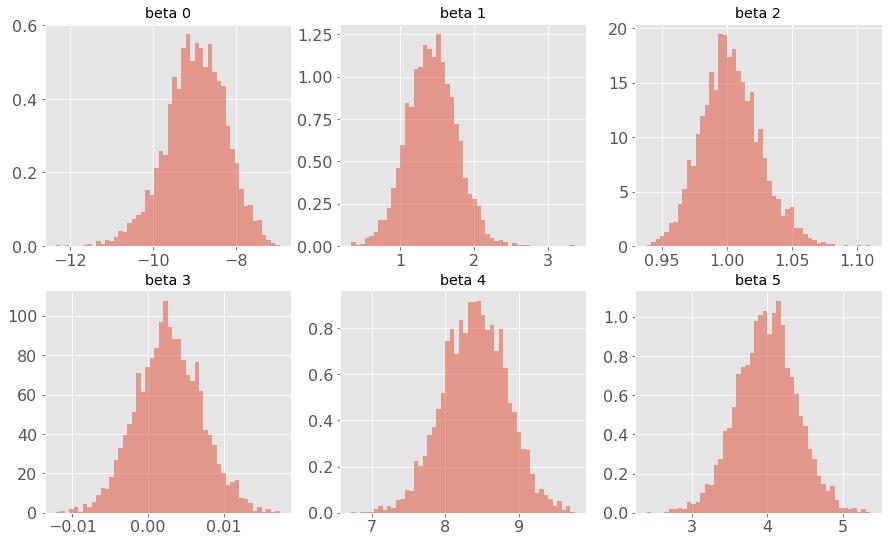

In [15]:
fig, ax = plt.subplots(figsize=(15,9))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(gibbs.traces['beta_trace'][:,i], density=True,  alpha=.5, bins=50)
    plt.title(f'beta {i}')

In [16]:
model = hsk.HomoskedasticModel(X, y)
model.fit()
model.betas

array([-8.96341766e+00,  1.42220244e+00,  1.00299784e+00,  2.65262217e-03,
        8.40442393e+00,  3.99152525e+00])

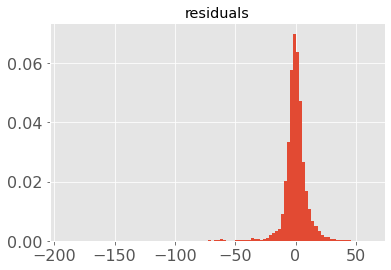

In [17]:
residuals = (model.predict(X) - y)
plt.hist(residuals, bins=100, density=True)
plt.title('residuals');

In [18]:
conf_interval = model.calculate_confidence_interval(num_samples=1000)

[-8.96345769e+00  1.42220497e+00  1.00299807e+00  2.65282054e-03
  8.40445418e+00  3.99154906e+00]


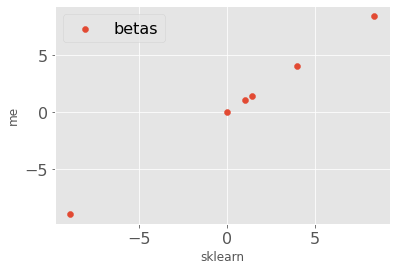

In [19]:
reg = LinearRegression().fit(X, y)
betas_sklearn = np.concatenate((reg.intercept_.flatten(), reg.coef_.flatten()))
print(betas_sklearn)
plt.scatter(betas_sklearn, model.betas, label='betas')
plt.xlabel('sklearn')
plt.ylabel('me')
plt.legend();

In [20]:
# calculate confidence interval using ex 1 (assume normal residuals)
var  = np.var(y - X_intercept@betas_sklearn, ddof=len(betas_sklearn))
cov_matrix = var*np.linalg.inv(X_intercept.T@X_intercept)
se = np.sqrt(np.diag(cov_matrix))
t_crit = norm(0, 1).ppf(1-0.025)
conf_low = betas_sklearn -t_crit*se
conf_up = betas_sklearn+t_crit*se

In [21]:
# or with statsmodels
est = sm.OLS(y, X_intercept)
conf = est.fit().conf_int(alpha=0.05, cols=None)

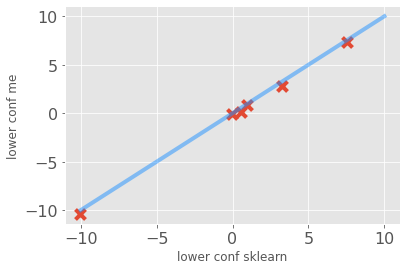

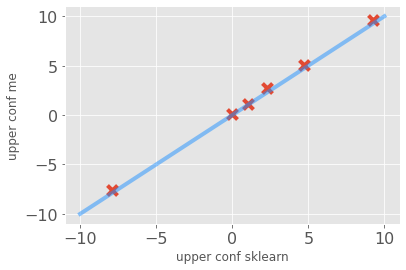

In [22]:
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.scatter(conf_low, conf_interval[0],s=100, marker='x')
plt.xlabel('lower conf sklearn')
plt.ylabel('lower conf me')
plt.figure()
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.scatter(conf_up, conf_interval[1],s=100, marker='x')
plt.xlabel('upper conf sklearn')
plt.ylabel('upper conf me');